# TorchVision Object Detection Finetuning Tutorial

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#torchvision-object-detection-finetuning-tutorial

# 0. 자신의 개발환경이 PyTorch GPU 버전을 사용할 수 있는지 확인해 봅니다.

In [24]:
import torch

In [25]:
torch.__version__

'2.2.2'

In [26]:
torch.cuda.is_available()

True

In [27]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights

In [28]:
weights = FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1

In [29]:
model = fasterrcnn_resnet50_fpn_v2(weights=weights)

In [30]:
model.rpn

RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [31]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
num_classes = 2  # 0 : background 1 : class (person)
in_features = 1024
model.roi_heads.box_predictor = FastRCNNPredictor(1024, 2)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

# 1. 다음 경로에서 PennFudanPed dataset 를 다운로드 받아 자신의 개발환경에 압축을 풉니다.

https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [32]:
from torchvision.io import read_image
image_path = 'PennFudanPed/PNGImages/FudanPed00001.png'

In [33]:
image = read_image(image_path)
image

tensor([[[211, 210, 212,  ..., 143, 146, 148],
         [179, 173, 170,  ..., 126, 128, 128],
         [204, 194, 188,  ..., 130, 131, 130],
         ...,
         [226, 217, 211,  ..., 183, 184, 185],
         [231, 219, 210,  ..., 187, 187, 186],
         [225, 227, 215,  ..., 190, 190, 187]],

        [[200, 199, 201,  ...,  96,  99, 101],
         [168, 162, 159,  ...,  79,  81,  81],
         [193, 183, 177,  ...,  83,  84,  83],
         ...,
         [220, 211, 205,  ..., 183, 184, 185],
         [225, 213, 204,  ..., 187, 187, 186],
         [219, 221, 209,  ..., 190, 190, 187]],

        [[182, 181, 183,  ...,  78,  81,  83],
         [150, 144, 141,  ...,  61,  63,  63],
         [175, 165, 159,  ...,  65,  66,  65],
         ...,
         [220, 211, 205,  ..., 183, 184, 185],
         [225, 213, 204,  ..., 187, 187, 186],
         [219, 221, 209,  ..., 190, 190, 187]]], dtype=torch.uint8)

In [34]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        #target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [35]:
import torchvision.transforms.v2 as v2

transforms = v2.Compose([
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True)
])

dataset = PennFudanDataset('PennFudanPed', transforms=transforms)

In [36]:
img, target = dataset[0]
img.shape, target

(torch.Size([3, 536, 559]),
 {'boxes': BoundingBoxes([[159., 181., 301., 430.],
                 [419., 170., 534., 485.]], format=BoundingBoxFormat.XYXY, canvas_size=[536, 559]),
  'labels': tensor([1, 1]),
  'image_id': 0,
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

In [37]:
from torchvision.utils import draw_bounding_boxes

In [38]:
img

Image([[[0.8275, 0.8235, 0.8314,  ..., 0.5608, 0.5725, 0.5804],
        [0.7020, 0.6784, 0.6667,  ..., 0.4941, 0.5020, 0.5020],
        [0.8000, 0.7608, 0.7373,  ..., 0.5098, 0.5137, 0.5098],
        ...,
        [0.8863, 0.8510, 0.8275,  ..., 0.7176, 0.7216, 0.7255],
        [0.9059, 0.8588, 0.8235,  ..., 0.7333, 0.7333, 0.7294],
        [0.8824, 0.8902, 0.8431,  ..., 0.7451, 0.7451, 0.7333]],

       [[0.7843, 0.7804, 0.7882,  ..., 0.3765, 0.3882, 0.3961],
        [0.6588, 0.6353, 0.6235,  ..., 0.3098, 0.3176, 0.3176],
        [0.7569, 0.7176, 0.6941,  ..., 0.3255, 0.3294, 0.3255],
        ...,
        [0.8627, 0.8275, 0.8039,  ..., 0.7176, 0.7216, 0.7255],
        [0.8824, 0.8353, 0.8000,  ..., 0.7333, 0.7333, 0.7294],
        [0.8588, 0.8667, 0.8196,  ..., 0.7451, 0.7451, 0.7333]],

       [[0.7137, 0.7098, 0.7176,  ..., 0.3059, 0.3176, 0.3255],
        [0.5882, 0.5647, 0.5529,  ..., 0.2392, 0.2471, 0.2471],
        [0.6863, 0.6471, 0.6235,  ..., 0.2549, 0.2588, 0.2549],
        ..

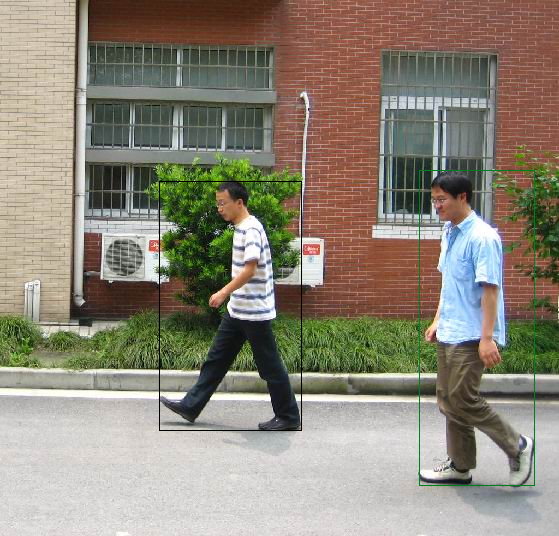

In [39]:
bbosx_image = draw_bounding_boxes(image, target['boxes'])
t = v2.ToPILImage()
t(bbosx_image)

In [17]:
!pip install pycocotools

In [42]:
from torchvision import transforms

image_transforms = {
    'train': transforms.v2.Compose([
        transforms.v2.RandomHorizontalFlip(),
        transforms.v2.ToImage(),
        transforms.v2.ToDtype(torch.float32, scale=True),
    ]),
    'test': transforms.v2.Compose([
        transforms.v2.ToImage(),
        transforms.v2.ToDtype(torch.float32, scale=True),
    ]),
}

dataset_train = PennFudanDataset('PennFudanPed', image_transforms['train'])
dataset_test = PennFudanDataset('PennFudanPed', image_transforms['test'])
dataset_test


In [43]:
# split the dataset in train and test set
indices = torch.randperm(len(dataset_train)).tolist()
dataset_train = torch.utils.data.Subset(dataset_train, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

In [63]:
len(dataset_train), len(dataset_test)

(120, 50)

# 2. 다음 명령어로 디렉토리의 데이터를 확인해 봅니다.

In [18]:
!dir PennFudanPed

 C ����̺��� �������� �̸��� �����ϴ�.
 ���� �Ϸ� ��ȣ: 58B3-92B1

 c:\k8_deep learning\chap06\PennFudanPed ���͸�

2024-12-26  ���� 09:51    <DIR>          .
2024-12-26  ���� 09:51    <DIR>          ..
2024-12-26  ���� 09:50             1,627 added-object-list.txt
2024-12-26  ���� 09:51    <DIR>          Annotation
2024-12-26  ���� 09:51    <DIR>          PedMasks
2024-12-26  ���� 09:51    <DIR>          PNGImages
2024-12-26  ���� 09:50             2,416 readme.txt
               2�� ����               4,043 ����Ʈ
               5�� ���͸�  352,956,297,216 ����Ʈ ����


# 3. 다운로드 받은 데이터 중 하나의 이미지를 읽어 봅니다. (hint: torchvision.io.read_image)

* 경로: PennFudanPed/PNGImages/FudanPed00001.png

In [19]:
from torchvision.io import read_image

# 4. 읽어 드린 이미지를 화면에 출력해 봅니다. - hint: image.permute(1, 2, 0), plt.imshow

# 5. 튜토리얼의 PennFudanDataset class 를 이용하여 dataset 객체를 생성하세요. (hint: 클래스의 생성자를 확인하여 어떤 인자들을 전달해야 하는지 파악합니다.)

* F.get_size 에러 발생 시: F.get_image_size 사용

In [20]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    pass

In [21]:
import torchvision.transforms.v2 as v2

transforms = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float, scale=True),
            ])

In [22]:
dataset[0][0].shape, dataset[0][1]['boxes'].shape

(torch.Size([3, 536, 559]), torch.Size([2, 4]))

# 6. dataset 으로부터 이미지, bbox, label 을 함께 화면에 표시하세요. (hint: torchvision.utils.draw_bounding_boxes, v2.ToPILImage())

In [23]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes

image_tensor, target = dataset[0]
boxes = target['boxes']
labels = target['labels']

AttributeError: module 'torchvision.transforms.functional' has no attribute 'get_size'

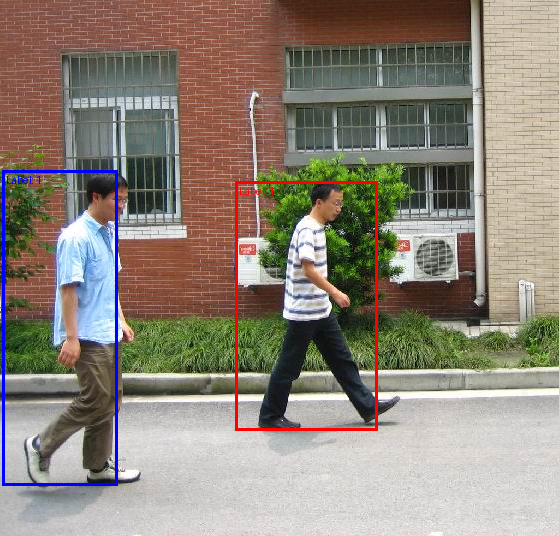

# 7. PennFudanDataset 객체를 두 개 만들어 dataset_train 와 dataset_test 변수에 저장합니다. 그런 다음 데이터를 읽을 수 있는지 테스트해 봅니다.

In [ ]:
from torchvision import transforms

image_transforms = {
    'train': transforms.v2.Compose([
        transforms.v2.RandomHorizontalFlip(),
        transforms.v2.ToImage(),
        transforms.v2.ToDtype(torch.float32, scale=True),
    ]),
    'test': transforms.v2.Compose([
        transforms.v2.ToImage(),
        transforms.v2.ToDtype(torch.float32, scale=True),
    ]),
}


In [ ]:
for X, y in dataset_train:
  print(type(X), X.shape)
  print(type(y), y['boxes'], y['labels']) # background and person
  print(y.keys())
  break

<class 'torchvision.tv_tensors._image.Image'> torch.Size([3, 536, 559])
<class 'dict'> BoundingBoxes([[159., 181., 301., 430.],
               [419., 170., 534., 485.]], format=BoundingBoxFormat.XYXY, canvas_size=[559, 536]) tensor([1, 1])
dict_keys(['boxes', 'masks', 'labels', 'image_id', 'area', 'iscrowd'])


In [ ]:
for X, y in dataset_test:
  print(type(X), X.shape)
  print(type(y), y['boxes'], y['labels']) # background and person
  print(y.keys())
  break

<class 'torchvision.tv_tensors._image.Image'> torch.Size([3, 536, 559])
<class 'dict'> BoundingBoxes([[159., 181., 301., 430.],
               [419., 170., 534., 485.]], format=BoundingBoxFormat.XYXY, canvas_size=[559, 536]) tensor([1, 1])
dict_keys(['boxes', 'masks', 'labels', 'image_id', 'area', 'iscrowd'])


# 8. 주어진 코드를 이용하여 train 과 test 로 데이터를 나눕니다. (120개, 50개)

In [ ]:
# split the dataset in train and test set
indices = torch.randperm(len(dataset_train)).tolist()
dataset_train = torch.utils.data.Subset(dataset_train, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

In [ ]:
len(dataset_train), len(dataset_test)

(120, 50)

# 9. Faster RCNN 모델을 생성합니다.

https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn_v2.html

* fasterrcnn_resnet50_fpn_v2 도우미 함수를 사용하세요.
* weights 는 FasterRCNN_ResNet50_FPN_V2_Weights 를 사용하세요.



FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

# 10. 튜토리얼의 get_model_instance_segmentation 함수를 참고하여 transfer learning 을 준비합니다. 오리지널 모델은 91개의 클래스를 탐지하므로 우리의 dataset에 맞게 2로 수정해야 합니다.

* 이때, mask 관련 코드는 사용하지 않습니다.

* 모델의 마지막 레이어의 출력이 2로 변경됐는지 확인해 봅니다.

* num_classes = 2  

* 0은 배경(background) 1은 사람(person)


In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 2
# Implement your code

model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

# 11. 모델을 훈련시키기 위해 필요한 파일을 다운로드 받아 자신의 개발환경에 복사합니다. (pycocotools 라이브러리 설치 필요)

* https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
* https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
* https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py
* https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
* https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py


In [ ]:
!pip install pycocotools

# 12. 튜토리얼에서는 train 코드를 제공합니다. 실습에 맞춰 수정된 코드를 자신의 개발환경에서 실행해 봅니다. (아래 코드를 수정하지 마세요!)

In [44]:
import utils
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=1,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [  0/120]  eta: 0:03:36  lr: 0.000047  loss: 0.7717 (0.7717)  loss_classifier: 0.6019 (0.6019)  loss_box_reg: 0.1387 (0.1387)  loss_objectness: 0.0305 (0.0305)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.8080  data: 0.0250  max mem: 1898
Epoch: [0]  [ 10/120]  eta: 0:00:42  lr: 0.000467  loss: 0.7717 (0.7438)  loss_classifier: 0.5445 (0.4914)  loss_box_reg: 0.2300 (0.2211)  loss_objectness: 0.0144 (0.0258)  loss_rpn_box_reg: 0.0034 (0.0055)  time: 0.3834  data: 0.0179  max mem: 2173
Epoch: [0]  [ 20/120]  eta: 0:00:31  lr: 0.000886  loss: 0.5935 (0.6235)  loss_classifier: 0.2878 (0.3444)  loss_box_reg: 0.2323 (0.2418)  loss_objectness: 0.0175 (0.0311)  loss_rpn_box_reg: 0.0034 (0.0062)  time: 0.2433  data: 0.0174  max mem: 2388
Epoch: [0]  [ 30/120]  eta: 0:00:26  lr: 0.001306  loss: 0.3653 (0.5266)  loss_classifier: 0.1165 (0.2666)  loss_box_reg: 0.2087 (0.2249)  loss_objectness: 0.0198 (0.0299)  loss_rpn_box_reg: 0.0022 (0.0051)  time: 0.2383  data: 0.0174  max mem: 2388


# 13. 주어진 코드를 이용하여 훈련된 모델을 테스트해 봅니다. 출력값을 확인해 봅니다.

In [60]:
model.eval()
for X, y in data_loader_test:
  X = X[0].to(device)
  predictions = model([X,])
  pred = predictions[0]
  break
pred

{'boxes': tensor([[265.2558,  18.9177, 378.4305, 372.4912],
         [116.7163,  28.0963, 194.3526, 321.9756],
         [ 30.1210,  30.6635, 116.8391, 325.0876],
         [  0.6798,  42.4157,  37.4694, 314.4680]], device='cuda:0',
        grad_fn=<StackBackward0>),
 'labels': tensor([1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9947, 0.9936, 0.9917, 0.0559], device='cuda:0',
        grad_fn=<IndexBackward0>)}

# 14. 예측 결과를 draw_bounding_boxes 를 이용하여 화면에 표시합니다.

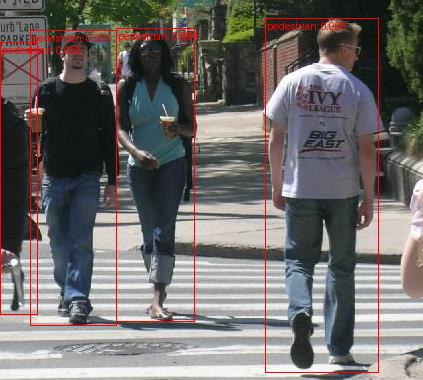

In [68]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes

pred_boxes = pred["boxes"]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
X = (255.0 * (X - X.min()) / (X.max() - X.min())).to(torch.uint8)
bbosx_image = draw_bounding_boxes(X, pred_boxes,pred_labels, colors="red")
st = v2.ToPILImage()
st(bbosx_image)



